# Computervision Lab 3 - Image formation and transformations

In [1]:
# imports
import os
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# name printing function
def print_name(im, name):
	im = cv2.putText(im, name, (10, im.shape[0]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
	return im

## The pinhole camera model
### Exercise 1
#### Question 1: What is the Camera Matrix for a 1080p Camera with a Horizontal Field of View of 90 Degrees? 

##### **1. FOV**  
The horizontal FOV is **90°**. The relationship between the focal length ($f$), the sensor width ($W$), and the FOV ($\theta$) is:  

$$
\tan\left(\frac{\theta}{2}\right) = \frac{W}{2f}
$$  

For a **1080p camera** (1920×1080 resolution), W = 1920 pixels:  

$$
\tan(45^\circ) = 1 = \frac{1920}{2f}
$$  

$$
f = \frac{1920}{2} = 960 \text{ pixels}
$$  

##### **2. Principal Point**  
The principal point $ (c_x, c_y) $ is at the image center:  

$$
c_x = \frac{1920}{2} = 960, \quad c_y = \frac{1080}{2} = 540
$$  

##### **3. Camera Matrix**  
The intrinsic camera matrix $K$ is:  

$$
K = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
= \begin{bmatrix}
960 & 0 & 960 \\
0 & 960 & 540 \\
0 & 0 & 1
\end{bmatrix}
$$  

#### Assignment 1:
- Create a virtual 3D cube with a side of 1 meter, defined as an 8x3 matrix containing the 3D coordinates
of the vertices of the cube relative to the cameraS, and a 12x2 array of edges described by pairs of vertex
indices that need to be connected by lines;

<img src="./img/cube.jpg" alt="Cube" width="400">

In [2]:
# Define the 3D coordinates of the cube vertices (8x3 matrix)
cube_vertices = np.array([
   [0, 0, 0],
   [1, 0, 0],
   [1, 1, 0],
   [0, 1, 0],
   [0, 0, 1],
   [1, 0, 1],
   [1, 1, 1],
   [0, 1, 1]
])

# Define the edges as pairs of vertex indices (12x2 matrix)
cube_edges = np.array([
   [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
   [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
   [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
])

- Project the 3D vertex coordinates to 2D image coordinates using your camera matrix from Question
1, and visualize the result by drawing the vertices and edges on an empty 1080p image. Pay attention
to the dimensions of your matrices, transpose as necessary and round the image coordinates to integer
pixels.

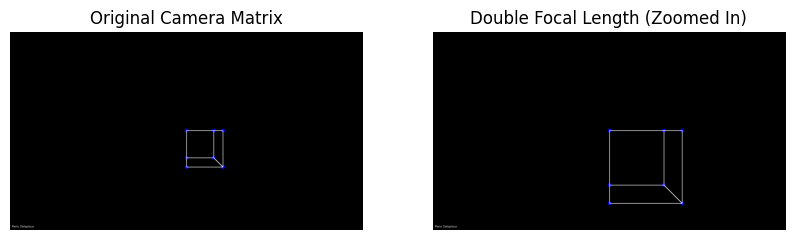

In [3]:
def create_camera_matrix(res:tuple,fov:int) -> np.array:
    # Calculate the focal length in pixels using the horizontal FOV
    f = res[0] / (2*np.tan(fov / 2))
    # Calculate the camera matrix
    fx = fy = f
    cx = res[0] / 2
    cy = res[1] / 2
    camera_matrix = np.array([[fx, 0, cx],
                            [0, fy, cy],
                            [0, 0, 1]])
    
    return camera_matrix

# Move the cube forward
tvec = np.array([0, 0, 3])
cube_vertices += tvec

# Set resolution and field of view
res = (1920, 1080)
fov = 90
K = create_camera_matrix(res, fov)

# Double the focal distance
K_double = K.copy()
K_double[0, 0] *= 2  # Double focal length (zoom in)
K_double[1, 1] *= 2

# Project 3D points to 2D
image_coord = np.dot(K, cube_vertices.T).T
image_coord2 = np.dot(K_double, cube_vertices.T).T

# Normalize homogeneous coordinates
for i in range(image_coord.shape[0]):
    if image_coord[i, 2] != 0:  # Avoid division by zero
        image_coord[i, 0] /= image_coord[i, 2]  
        image_coord[i, 1] /= image_coord[i, 2]  
    if image_coord2[i, 2] != 0:
        image_coord2[i, 0] /= image_coord2[i, 2]  
        image_coord2[i, 1] /= image_coord2[i, 2]  

# Convert to integer pixel coordinates
image_coord = np.round(image_coord[:, :2]).astype(int)
image_coord2 = np.round(image_coord2[:, :2]).astype(int)

# Create empty images
image = np.zeros((1080, 1920, 3), dtype=np.uint8)
image2 = np.zeros((1080, 1920, 3), dtype=np.uint8)

# Draw vertices
for point in image_coord:
    cv2.circle(image, tuple(point), 10, (0, 0, 255), -1)  # Red points

for point in image_coord2:
    cv2.circle(image2, tuple(point), 10, (0, 0, 255), -1)  # Red points

# Draw edges
for edge in cube_edges:
    cv2.line(image, tuple(image_coord[edge[0]]), tuple(image_coord[edge[1]]), (255, 255, 255), 2)
    cv2.line(image2, tuple(image_coord2[edge[0]]), tuple(image_coord2[edge[1]]), (255, 255, 255), 2)
    
# Save output
image = print_name(image, "Rens Delaplace")
cv2.imwrite("out/assignment1.png", image)
image2 = print_name(image2, "Rens Delaplace")
cv2.imwrite("out/assignment1_zoomed.png", image2)

# Display the results
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original Camera Matrix")

fig.add_subplot(1, 2, 2)
plt.imshow(image2)
plt.axis('off')
plt.title("Double Focal Length (Zoomed In)")

plt.show()

#### Question 2: If you double the focal distance, what happens to the picture?

If you double the focal distance, the image will appear more zoomed in. The projected image will be scaled up by a factor of 2, making objects appear larger and closer. Doubling the focal length will also halve the field of view, meaning the camera will capture a narrower view of the scene.

For the camera matrix, doubling the focal length will result in:

$$
K_{\text{new}} = \begin{bmatrix}
2f & 0 & c_x \\
0 & 2f & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

## Camera calibration
#### **Question 3:** Why are there only even powers in this polynomial in r?
Radial distortion is symmetric around the optical center, so the correction depends only on the distance from the center. Even powers preserve this symmetry, while odd powers would break it. The correction moves each distorted pixel closer to or further from the image center, restoring straight lines.

### Exercise 2
#### **Assignment 2:** Determine the intrinsic matrix and distortion parameters of the gopro camera used to shoot the calibration sequence.

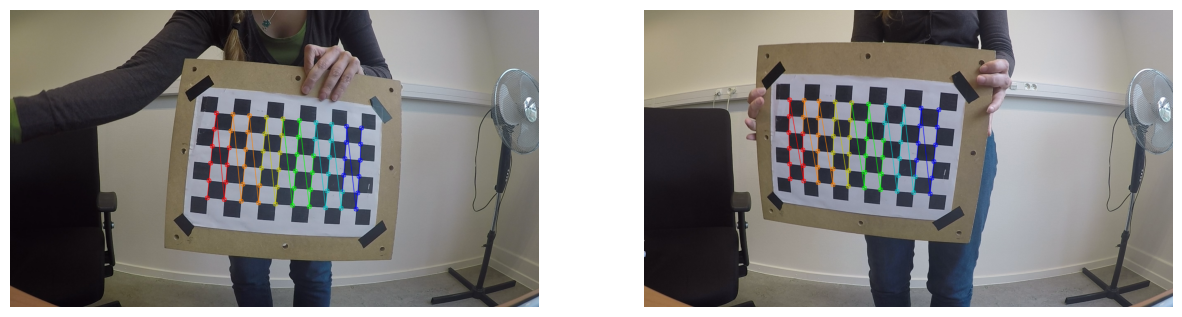

In [4]:
# Define checkerboard size (rows, cols)
grid = (10, 6)  # 10 columns, 6 rows (inner corners)

# Termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points in real-world space (Z=0)
objp = np.zeros((grid[0] * grid[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:grid[0], 0:grid[1]].T.reshape(-1, 2)

# Lists to store object points (3D) and image points (2D)
objpoints = []
imgpoints = []

# Get all calibration images
images = glob.glob("./img/calibration_frames/*.png")  # Automatically fetches only images

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
count = 0

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (grid[1], grid[0]), None)

    if ret:
        objpoints.append(objp)  # Store 3D points
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)  # Store refined 2D points

        # Draw detected corners on the first 2 images 
        if count < 2:
            cv2.drawChessboardCorners(img, (grid[0], grid[1]), corners2, ret)
            axs[count].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axs[count].axis("off")
            count += 1
            # Save output
            img = print_name(img, "Rens Delaplace")
            cv2.imwrite(f"out/assignment2_{count}.png", img)

plt.show()

In [5]:
# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print results in a readable format
print("\n=== Camera Calibration Results ===")
print(f"Reprojection Error: {ret:.6f}\n")

print("Intrinsic Camera Matrix (K):")
print(np.array2string(mtx, formatter={'float_kind': lambda x: f"{x:.6f}"}), "\n")

print("Distortion Coefficients:")
print(np.array2string(dist, formatter={'float_kind': lambda x: f"{x:.6f}"}))



=== Camera Calibration Results ===
Reprojection Error: 39.966012

Intrinsic Camera Matrix (K):
[[10277.482509 0.000000 661.340356]
 [0.000000 8534.124935 356.393022]
 [0.000000 0.000000 1.000000]] 

Distortion Coefficients:
[[-33.644115 1742.482521 0.050035 0.224244 14527.354872]]


#### **Assignment 3:** Do the calibration procedure for 5 different random subsets of 20 frames. Print the camera matrix for each set.

In [6]:
random.shuffle(images)
num_subsets = 5
subset_size = 20
calibration_results = []

for i in range(num_subsets):
    objpoints_subset = []  # 3D points
    imgpoints_subset = []  # 2D points

    subset = random.sample(images, subset_size)  # Select 20 random images

    for fname in subset:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (grid[1], grid[0]), None)

        if ret:
            objpoints_subset.append(objp)  # Store 3D points
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints_subset.append(corners2)  # Store refined 2D points

    # Perform camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints_subset, imgpoints_subset, gray.shape[::-1], None, None
    )

    # Store results
    calibration_results.append({"subset": subset, "error": ret, "mtx": mtx, "dist": dist})

    # Print the intrinsic matrix for this subset
    print(f"\n=== Camera Matrix for Subset {i+1} ===")
    print(np.array2string(mtx, formatter={'float_kind': lambda x: f"{x:.6f}"}))


=== Camera Matrix for Subset 1 ===
[[3762.833897 0.000000 644.794057]
 [0.000000 1570.055028 363.572750]
 [0.000000 0.000000 1.000000]]

=== Camera Matrix for Subset 2 ===
[[4155.087556 0.000000 709.773663]
 [0.000000 4103.955700 372.672954]
 [0.000000 0.000000 1.000000]]

=== Camera Matrix for Subset 3 ===
[[1884.828963 0.000000 639.964185]
 [0.000000 6398.728700 361.430476]
 [0.000000 0.000000 1.000000]]

=== Camera Matrix for Subset 4 ===
[[11222.480213 0.000000 654.134554]
 [0.000000 8784.595713 346.302777]
 [0.000000 0.000000 1.000000]]

=== Camera Matrix for Subset 5 ===
[[5740.733543 0.000000 604.900003]
 [0.000000 3237.365797 347.785184]
 [0.000000 0.000000 1.000000]]


#### **Question 4:** How can you find out which calibration is the best? Look in the opencv documentation.
To determine which calibration is the best, we need to evaluate the reprojection error, which quantifies how well the estimated camera parameters align with the actual observed image points.
#### **Assignment 4:** Use your best calibration result to undistort one of the frames from the sequence. Lines that are straight in reality should be straight in your rectified image now.

In [7]:
# Find the best calibration result based on the lowest reprojection error
best_result = min(calibration_results, key=lambda x: x["error"])

# Extract the best camera matrix and distortion coefficients
best_mtx = best_result["mtx"]
best_dist = best_result["dist"]

print(f"Best calibration error: {best_result['error']:.6f}")
print("Best Camera Matrix:\n", best_mtx)
print("Best Distortion Coefficients:\n", best_dist)

Best calibration error: 35.205728
Best Camera Matrix:
 [[3.76283390e+03 0.00000000e+00 6.44794057e+02]
 [0.00000000e+00 1.57005503e+03 3.63572750e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Best Distortion Coefficients:
 [[-1.84551863e+00 -1.30902142e+01  3.14644481e-02  9.44031128e-02
   1.86540628e+02]]


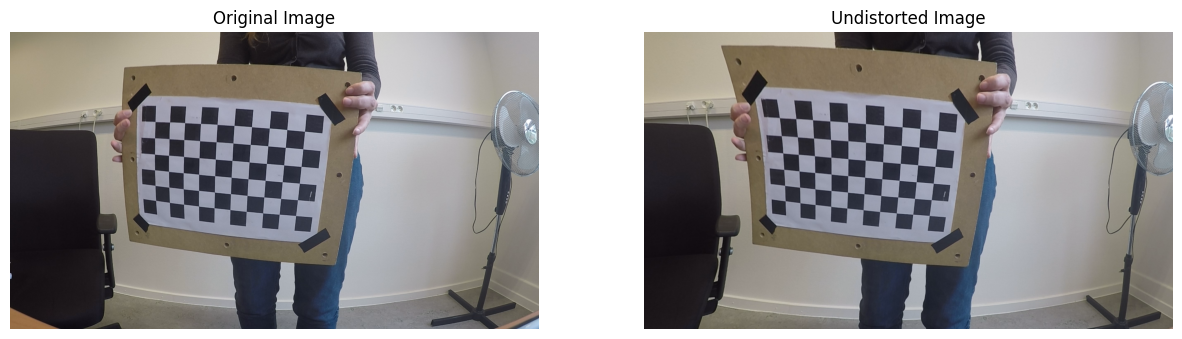

In [9]:
test_img = cv2.imread("./img/calibration_frames/img_0004.png")

# Get best calibration parameters
best_mtx = best_result["mtx"]
best_dist = best_result["dist"]

# Undistort the image using the original camera matrix
undistorted_img = cv2.undistort(test_img, best_mtx, best_dist, None, best_mtx)

# Save and display the undistorted image
cv2.imwrite(f"out/assignment4.png", undistorted_img)


# Display results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
axs[1].set_title("Undistorted Image")
axs[1].axis("off")

plt.show()

## Geometric transformations
### Exercise 3
#### **Assignment 5:** Shear shadow.png so that the photographer’s shadow becomes vertical. Size your target image so that it will be large enough to accommodate the sheared image, and make sure that all parts of the original image are visible. You can add translation by placing pixel offsets in the third column.

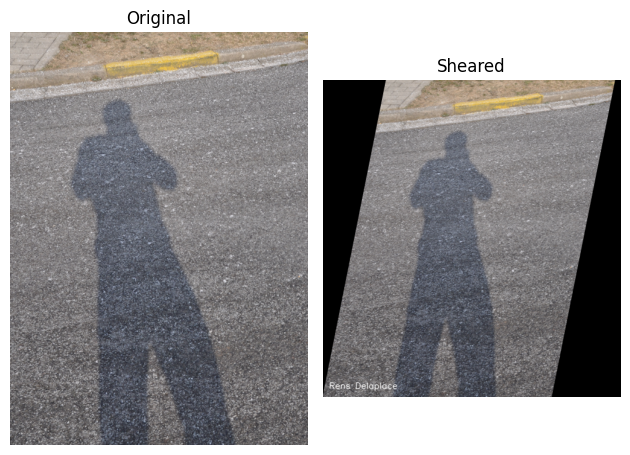

In [10]:
shadow_img = cv2.imread("./img/shadow.png")
m = -0.2
dx = 110
shear_mtx = np.array([
    [1, m ,dx],
    [0 , 1, 0]
])

result_img_shadow = cv2.warpAffine(shadow_img,shear_mtx,(int(shadow_img.shape[1]*1.3),shadow_img.shape[0]))

# Save output
result_img_shadow = print_name(result_img_shadow, "Rens Delaplace")
cv2.imwrite("out/assignment5.png", result_img_shadow)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(cv2.cvtColor(shadow_img, cv2.COLOR_BGR2RGB))
axes[0].axis('off') 
axes[0].set_title('Original') 

axes[1].imshow(cv2.cvtColor(result_img_shadow, cv2.COLOR_BGR2RGB))
axes[1].axis('off')  
axes[1].set_title('Sheared')  


plt.tight_layout()
plt.show()

### Exercise 4
Write a program that applies a perspective transform to obtain a perpendicular view on the ground plane,
also called a bird’s eye view.
#### **Assignment 6:** Apply a perspective transform to shadow box.png so that the photographer in not only stands vertically, but is also proportionally correct. In your program you click on the 4 corners of the tetragon that you want to transform into a rectangle, after which the right perspective transformation is searched for and executed. 

In [11]:
# Load the image
image = cv2.imread("img/shadow_box.png")
clone = image.copy()
points = []

# Mouse callback function
def get_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(clone, (x, y), 5, (0, 255, 0), -1)  # Draw point
        cv2.imshow("Select 4 Points", clone)

        if len(points) == 4:
            cv2.destroyAllWindows()


cv2.imshow("Select 4 Points", clone)
cv2.setMouseCallback("Select 4 Points", get_points)
cv2.waitKey(0)
if len(points) != 4:
    print("Error: Select exactly 4 points.")
    exit()

# Convert points to numpy array
src_points = np.array(points, dtype=np.float32)

x_min, y_min = np.min(src_points, axis=0)
x_max, y_max = np.max(src_points, axis=0)

dst_points = np.array([
    [x_min, y_min],  # Top-left
    [x_max, y_min],  # Top-right
    [x_max, y_max],  # Bottom-right
    [x_min, y_max]   # Bottom-left
], dtype=np.float32)

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(src_points, dst_points)

# Apply the warp to the **entire** image
warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

# Save output
warped = print_name(warped, "Rens Delaplace")
cv2.imwrite("out/assignment6.png", warped)

# Show result
cv2.imshow("Bird's Eye View", warped)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### **Question 5**: Can you do this for 5 point correspondences instead of 4? How could such an overdetermined system be solved?
Yes, with 5+ points, use least squares or `cv2.findHomography()`.